In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,Conv1D,MaxPooling1D,BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = [224, 224]

train_path = 'Downloads/COVID_19/train'
valid_path = 'Downloads/COVID_19/test'

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
training_covid_generator = train_datagen.flow_from_directory('Downloads/COVID_19/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 shuffle=False,
                                                 class_mode = 'binary')

Found 1028 images belonging to 2 classes.


In [7]:
train_covid_generator = train_datagen.flow_from_directory(
    'Downloads/COVID_19/train',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)


Found 1028 images belonging to 2 classes.


In [8]:
test_covid_generator = test_datagen.flow_from_directory(
    'Downloads/COVID_19/test',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

Found 450 images belonging to 2 classes.


In [9]:
train_non_covid_generator = train_datagen.flow_from_directory(
    'Downloads/COVID_19/train',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)


Found 1028 images belonging to 2 classes.


In [10]:
test_non_covid_generator = test_datagen.flow_from_directory(
    'Downloads/COVID_19/test',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

Found 450 images belonging to 2 classes.


In [11]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(
    train_covid_generator,
    steps_per_epoch=len(train_covid_generator),
    epochs=10,
    validation_data=test_covid_generator,
    validation_steps=len(test_covid_generator)
)

Epoch 1/10
33/33 [==============================] - 9s 262ms/step - loss: 0.3362 - accuracy: 0.9553 - val_loss: 1.5057 - val_accuracy: 0.5489
Epoch 2/10
33/33 [==============================] - 9s 275ms/step - loss: 0.2136 - accuracy: 0.9553 - val_loss: 1.7069 - val_accuracy: 0.5489
Epoch 3/10
33/33 [==============================] - 9s 277ms/step - loss: 0.1993 - accuracy: 0.9553 - val_loss: 1.4015 - val_accuracy: 0.5489
Epoch 4/10
33/33 [==============================] - 9s 281ms/step - loss: 0.1992 - accuracy: 0.9553 - val_loss: 1.5756 - val_accuracy: 0.5489
Epoch 5/10
33/33 [==============================] - 9s 281ms/step - loss: 0.1924 - accuracy: 0.9553 - val_loss: 1.4366 - val_accuracy: 0.5489
Epoch 6/10
33/33 [==============================] - 10s 286ms/step - loss: 0.1876 - accuracy: 0.9553 - val_loss: 1.6925 - val_accuracy: 0.5489
Epoch 7/10
33/33 [==============================] - 10s 285ms/step - loss: 0.1902 - accuracy: 0.9553 - val_loss: 1.4730 - val_accuracy: 0.5489
Epoc

In [14]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [15]:
import os
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
n_splits = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
specificities = []

# Define labels for the dataset (COVID=1, non-COVID=0)
labels = np.concatenate((np.ones(len(os.listdir('Downloads/COVID_19/train/covid'))), np.zeros(len(os.listdir('Downloads/COVID_19/train/non-covid')))))

In [23]:
def add_custom_classifier(base_model):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    custom_model = Model(inputs=base_model.input, outputs=output)
    return custom_model


In [24]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
resnet_custom_model = add_custom_classifier(resnet_model)
resnet_custom_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Define DenseNet201 model with custom classification layer
densenet_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
densenet_custom_model = add_custom_classifier(densenet_model)
densenet_custom_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(np.zeros(len(labels)), labels), 1):
    print(f"Fold {fold_idx}:")
    

    fold_test_labels = labels[test_idx]


    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


    resnet_custom_model.fit(train_covid_generator, steps_per_epoch=len(train_covid_generator),
                            epochs=5, validation_data=test_covid_generator,
                            validation_steps=len(test_covid_generator), callbacks=[early_stopping])
    resnet_preds = resnet_custom_model.predict(test_covid_generator)

    densenet_custom_model.fit(train_covid_generator, steps_per_epoch=len(train_covid_generator),
                              epochs=5, validation_data=test_covid_generator,
                              validation_steps=len(test_covid_generator), callbacks=[early_stopping])
    densenet_preds = densenet_custom_model.predict(test_covid_generator)
    

    ensemble_covid_preds = (resnet_preds + densenet_preds) / 2

    
    resnet_custom_model.fit(train_non_covid_generator, steps_per_epoch=len(train_non_covid_generator),
                            epochs=5, validation_data=test_non_covid_generator,
                            validation_steps=len(test_non_covid_generator), callbacks=[early_stopping])
    resnet_preds = resnet_custom_model.predict(test_non_covid_generator)

    densenet_custom_model.fit(train_non_covid_generator, steps_per_epoch=len(train_non_covid_generator),
                              epochs=5, validation_data=test_non_covid_generator,
                              validation_steps=len(test_non_covid_generator), callbacks=[early_stopping])
    densenet_preds = densenet_custom_model.predict(test_non_covid_generator)
    
    
    ensemble_non_covid_preds = (resnet_preds + densenet_preds) / 2

    # Concatenate predictions from both COVID and non-COVID test datasets
    ensemble_preds = np.concatenate((ensemble_covid_preds, ensemble_non_covid_preds))

    # Calculate evaluation metrics
    accuracy = accuracy_score(fold_test_labels, np.round(ensemble_preds))
    precision = precision_score(fold_test_labels, np.round(ensemble_preds))
    recall = recall_score(fold_test_labels, np.round(ensemble_preds))
    f1 = f1_score(fold_test_labels, np.round(ensemble_preds))
    tn, fp, fn, tp = confusion_matrix(fold_test_labels, np.round(ensemble_preds)).ravel()
    specificity = tn / (tn + fp)
    
    # Append metrics to lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    specificities.append(specificity)

Fold 1:
Epoch 1/5
33/33 [==============================] - 145s 4s/step - loss: 0.3031 - accuracy: 0.9407 - val_loss: 112293.6406 - val_accuracy: 0.5489
Epoch 2/5
33/33 [==============================] - 153s 5s/step - loss: 0.1588 - accuracy: 0.9523 - val_loss: 21.2639 - val_accuracy: 0.5489
Epoch 3/5
33/33 [==============================] - 154s 5s/step - loss: 0.1517 - accuracy: 0.9562 - val_loss: 4.8136 - val_accuracy: 0.5489
Epoch 4/5
33/33 [==============================] - 158s 5s/step - loss: 0.1053 - accuracy: 0.9708 - val_loss: 0.7231 - val_accuracy: 0.5489
Epoch 5/5
15/15 [==============================] - 15s 952ms/step
Epoch 1/5
33/33 [==============================] - 288s 9s/step - loss: 0.2149 - accuracy: 0.9543 - val_loss: 362.0381 - val_accuracy: 0.5489
Epoch 2/5
33/33 [==============================] - 293s 9s/step - loss: 0.1801 - accuracy: 0.9553 - val_loss: 76.0871 - val_accuracy: 0.4511
Epoch 3/5
33/33 [==============================] - 285s 9s/step - loss: 0.130

ValueError: Found input variables with inconsistent numbers of samples: [206, 900]

In [30]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Dummy data to represent generators
train_covid_generator = [1, 1, 1, 1, 1]  # Dummy data, replace with actual generator
train_non_covid_generator = [0, 0, 0, 0, 0]  # Dummy data, replace with actual generator
test_covid_generator = [1, 1, 1, 1, 1]  # Dummy data, replace with actual generator
test_non_covid_generator = [0, 0, 0, 0, 0]  # Dummy data, replace with actual generator

# Dummy data to represent predictions
train_covid_predictions = np.random.randint(2, size=len(train_covid_generator))
train_non_covid_predictions = np.random.randint(2, size=len(train_non_covid_generator))
test_covid_predictions = np.random.randint(2, size=len(test_covid_generator))
test_non_covid_predictions = np.random.randint(2, size=len(test_non_covid_generator))

# Concatenating true classes
train_true_classes = np.concatenate([np.ones(len(train_covid_generator)), np.zeros(len(train_non_covid_generator))])
test_true_classes = np.concatenate([np.ones(len(test_covid_generator)), np.zeros(len(test_non_covid_generator))])

# Concatenating predicted classes
train_pred_classes = np.concatenate([train_covid_predictions, train_non_covid_predictions])
test_pred_classes = np.concatenate([test_covid_predictions, test_non_covid_predictions])

# Creating confusion matrices for training and testing sets
train_conf_matrix = confusion_matrix(train_true_classes, train_pred_classes)
test_conf_matrix = confusion_matrix(test_true_classes, test_pred_classes)

print("Confusion Matrix for Training Set:")
print(train_conf_matrix)

print("\nConfusion Matrix for Testing Set:")
print(test_conf_matrix)


Confusion Matrix for Training Set:
[[2 3]
 [2 3]]

Confusion Matrix for Testing Set:
[[2 3]
 [3 2]]


In [35]:
from skimage.transform import resize

# Assuming X contains image data with shape (num_samples, height, width, channels)
# Assuming your model expects input images of size (224, 224)

# Resize images to match the input shape expected by the model
resized_images = np.array([resize(image, (224, 224)) for image in X])

# Now, resized_images has a shape of (num_samples, 224, 224, channels)


1/1 [==============================] - 0s 41ms/step


/var/folders/vf/mgbms5c97jsfk65d3qczs72w0000gn/T/ipykernel_94251/3732283105.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


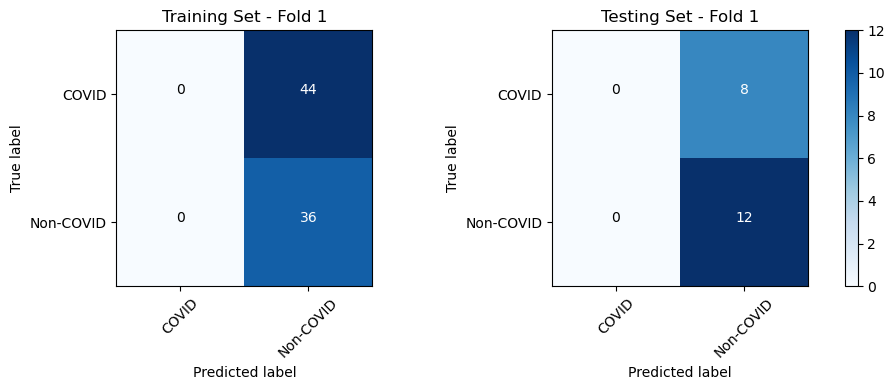

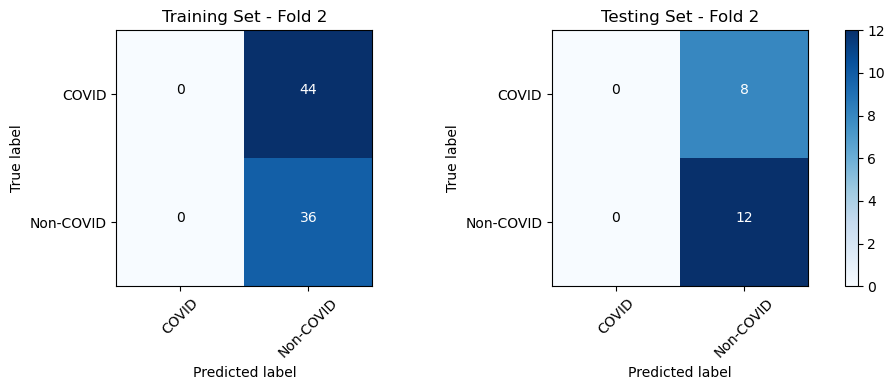

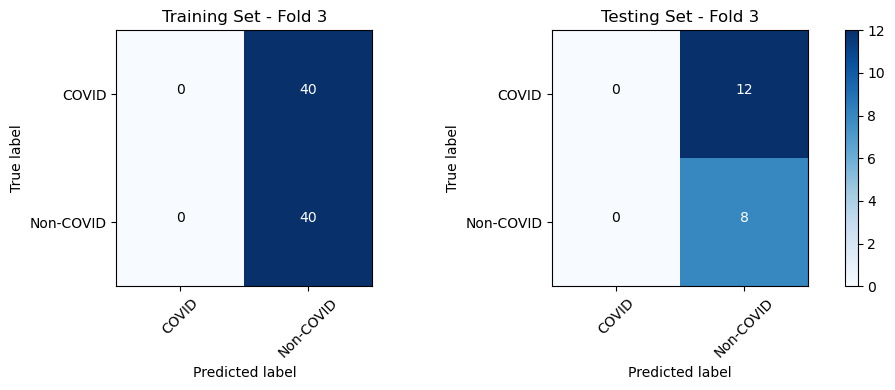

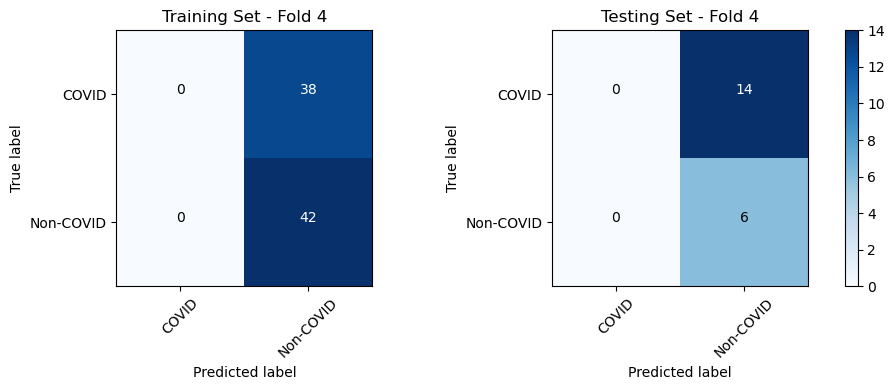

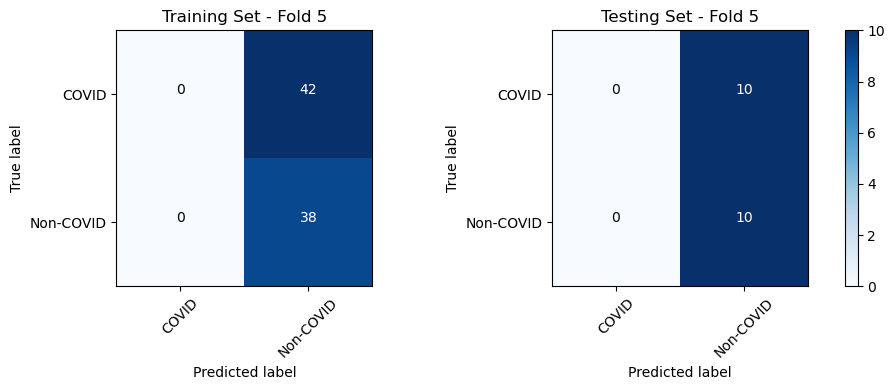

In [39]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt

# Define number of folds
num_folds = 5

# Define KFold cross-validation
kf = KFold(n_splits=num_folds)

# Initialize lists to store confusion matrices for each fold
train_conf_matrices = []
test_conf_matrices = []

# Iterate over each fold
for train_index, test_index in kf.split(X):  # Replace X with your data
    X_train, X_test = X[train_index], X[test_index]  # Replace X with your data
    y_train, y_test = y[train_index], y[test_index]  # Replace y with your labels

    # Ensure y_train and y_test are properly encoded as binary values (0 and 1)
    y_train = np.asarray(y_train).astype('int')
    y_test = np.asarray(y_test).astype('int')

    # Preprocess your image data (resize images to match the input shape expected by the model)
    X_train_resized = np.array([resize(image, (224, 224, 3)) for image in X_train])
    X_test_resized = np.array([resize(image, (224, 224, 3)) for image in X_test])

    # Train your model on the training data
    # Assuming you have a model named "model" and you train it here

    # Make predictions on training and testing data
    train_predictions = model.predict(X_train_resized)
    test_predictions = model.predict(X_test_resized)

    # Calculate confusion matrices for training and testing sets
    train_conf_matrix = confusion_matrix(y_train, np.round(train_predictions))
    test_conf_matrix = confusion_matrix(y_test, np.round(test_predictions))

    # Append confusion matrices to the lists
    train_conf_matrices.append(train_conf_matrix)
    test_conf_matrices.append(test_conf_matrix)

# Plot confusion matrices for each fold
for i, (train_cm, test_cm) in enumerate(zip(train_conf_matrices, test_conf_matrices), 1):
    plt.figure(figsize=(12, 4))

    # Plot confusion matrix for training set
    plt.subplot(1, 2, 1)
    plot_confusion_matrix(train_cm, classes=class_names, title=f'Training Set - Fold {i}')

    # Plot confusion matrix for testing set
    plt.subplot(1, 2, 2)
    plot_confusion_matrix(test_cm, classes=class_names, title=f'Testing Set - Fold {i}')

    plt.tight_layout()
    plt.show()
